In [48]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [49]:
# Read the data
hitters = pd.read_csv("/Users/ruojiakuang/Desktop/GSB S544 Computing and Machine Learning for Business Analytics/dataset/Hitters.csv")

# Get rid of columns with mostly NaN values
good_cols = hitters.isna().sum() < 100
hitters = hitters.loc[:,good_cols]

# Drop other NAs
hitters = hitters.dropna()

In [50]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [51]:
X = hitters.drop(["Salary"], axis = 1)
y = hitters["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

# Part1 A. Regression without regularization

In [52]:
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

lr_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x143130dd0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x145102e10>)])),
                ('linear_regression', LinearRegression())])

In [53]:
lr_pipeline_fitted = lr_pipeline.fit(X, y)
lr_pipeline_fitted.named_steps['linear_regression'].coef_

array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,
        -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,
         53.73248973,  -22.16086217])

In [54]:
# Remove rows with missing 'Salary' values
hitters_cleaned = hitters.dropna(subset=['Salary'])

# Define predictors and target
X = hitters_cleaned.drop('Salary', axis=1)
y = hitters_cleaned['Salary']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and linear regression model
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline to the full dataset
lr_pipeline.fit(X, y)

# Extract coefficients from the linear regression model
model_coefficients = lr_pipeline.named_steps['regressor'].coef_

# Map coefficients to their corresponding feature names
feature_names = np.concatenate([numerical_cols, preprocessor.named_transformers_['cat'].get_feature_names_out()])
coefficients = dict(zip(feature_names, model_coefficients))

# Sort coefficients by absolute value
sorted_coefficients = dict(sorted(coefficients.items(), key=lambda item: abs(item[1]), reverse=True))

# Perform cross-validation to estimate MSE
mse_scores = -cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse = np.mean(mse_scores)

sorted_coefficients, mean_mse

({'CRuns': 480.747134770793,
  'CAtBat': -391.03865466353824,
  'Hits': 337.8304794814835,
  'AtBat': -291.09455569714925,
  'CRBI': 260.68988580523126,
  'CWalks': -213.8922586429127,
  'Walks': 135.07389695131255,
  'CHits': 86.68761663772091,
  'PutOuts': 78.76129639492675,
  'Runs': -60.5724786055111,
  'Division_W': -58.42462281843828,
  'Division_E': 58.42462281843723,
  'Assists': 53.73248973474432,
  'HmRun': 37.85383676434323,
  'League_N': 31.299711517594083,
  'League_A': -31.299711517594076,
  'RBI': -26.99498378992112,
  'Errors': -22.16086217422561,
  'Years': -16.69335887510299,
  'CHmRun': -14.18172332300868,
  'NewLeague_N': -12.381162554200458,
  'NewLeague_A': 12.381162554199951},
 121136.3103181688)

The coefficient of Cruns is 480.75, suggesting that career runs scored has a significant positive impact on salary. The coefficient of CAtBat is -391.04 indicating that one unit increse in number of time at bat will cause a negative 391.04 units impact on salary. 

The estimated Mean Squared Error (MSE) from cross-validation is approximately 121,136.31. This value represents the average squared difference between the actual and predicted salaries. A lower MSE indicates a more accurate model.

# B. Ridge regression

In [55]:
from sklearn.model_selection import GridSearchCV

# Creating the ridge regression model
ridge_reg = Ridge()

# Creating a pipeline that first preprocesses the data and then applies ridge regression
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', ridge_reg)])

# Parameters for GridSearchCV
param_grid = {
    'regressor__alpha': [0.1, 1, 10, 100, 1000]  # Different values for lambda (alpha in Ridge)
}

# Setting up the GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X, y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [56]:
# Extracting the best hyperparameter (lambda) and corresponding mean cross-validated MSE
best_lambda = grid_search.best_params_['regressor__alpha']
best_mse = -grid_search.best_score_

# Fitting the pipeline on the full dataset with the chosen lambda
best_model = grid_search.best_estimator_
best_model.fit(X, y)

# Getting the coefficients from the ridge regression model
ridge_coef = best_model.named_steps['regressor'].coef_

# Since we have one-hot encoded some variables, we need to adjust the feature names
# Get feature names after preprocessing
ohe_categories = best_model.named_steps['preprocessor'].named_transformers_['cat'].categories_
new_categorical_features = [f'{col}_{cat}' for col, cats in zip(categorical_cols, ohe_categories) for cat in cats]
all_features = np.concatenate([numerical_cols, new_categorical_features])

# Pairing coefficients with their corresponding feature names
feature_coef = pd.Series(ridge_coef, index=all_features)

# Sorting the coefficients by their absolute values to find the most influential ones
sorted_coef = feature_coef.abs().sort_values(ascending=False)

best_lambda, best_mse, sorted_coef.head()

(1,
 119144.43267691582,
 CRuns     320.412169
 Hits      296.645050
 AtBat     270.686441
 CAtBat    225.406548
 CWalks    184.423611
 dtype: float64)

The MSE you would expect is 119144.43 if you used this pipeline to predict 1989 salaries.

# C. Lasso Regression

In [57]:
# Creating the Lasso regression model
lasso_reg = Lasso(max_iter=10000)  # Increasing max_iter for convergence

# Creating a pipeline that first preprocesses the data and then applies Lasso regression
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', lasso_reg)])

# Parameters for GridSearchCV for Lasso
lasso_param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10]  # Different values for lambda in Lasso
}

# Setting up the GridSearchCV for Lasso
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Fit the grid search to the data for Lasso
lasso_pipeline_fitted = lasso_grid_search.fit(X, y)

In [58]:
# Extracting the best hyperparameter (lambda) and corresponding mean cross-validated MSE
best_lambda = lasso_grid_search.best_params_['regressor__alpha']
best_mse = -lasso_grid_search.best_score_

# Fitting the pipeline on the full dataset with the chosen lambda
best_model = lasso_grid_search.best_estimator_
best_model.fit(X, y)

# Getting the coefficients from the lasso regression model
lasso_coef = best_model.named_steps['regressor'].coef_

# Since we have one-hot encoded some variables, we need to adjust the feature names
# Get feature names after preprocessing
ohe_categories = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
all_features = np.concatenate([numerical_cols, ohe_categories])

# Pairing coefficients with their corresponding feature names
feature_coef = pd.Series(lasso_coef, index=all_features)

# Sorting the coefficients by their absolute values to find the most influential ones
sorted_coef = feature_coef.abs().sort_values(ascending=False)

best_lambda, best_mse, sorted_coef.head()

(1,
 119758.2278152887,
 CRuns     375.565034
 Hits      304.358267
 AtBat     282.369623
 CRBI      192.616442
 CWalks    189.643123
 dtype: float64)

The MSE you would expect is 119758.23 if you used this pipeline to predict 1989 salaries.

# D. Elastic Net

In [63]:
# Creating a pipeline with ElasticNet and the preprocessor
elastic_net_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

# Parameters for grid search
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100],
    'regressor__l1_ratio': [0.1, 0.5, 0.9]
}

# Grid search with cross-validation
elastic_net_grid_search = GridSearchCV(elastic_net_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fitting the grid search
elastic_net_grid_search.fit(X, y)

# Best parameters
best_params = elastic_net_grid_search.best_params_
best_params

/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e+05, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.977e+05, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}

In [64]:
best_mse = -elastic_net_grid_search.best_score_
# Updating the pipeline with the best parameters
elastic_net_pipeline.set_params(**{'regressor__alpha': best_params['regressor__alpha'], 
                                   'regressor__l1_ratio': best_params['regressor__l1_ratio']})

# Fitting the model to the full dataset
best_model = elastic_net_pipeline.fit(X, y)

# Getting the coefficients from the ridge regression model
elastic_net_coef = best_model.named_steps['regressor'].coef_

# Since we have one-hot encoded some variables, we need to adjust the feature names
# Get feature names after preprocessing
ohe_categories = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
all_features = np.concatenate([numerical_cols, ohe_categories])

# Pairing coefficients with their corresponding feature names
feature_coef = pd.Series(elastic_net_coef, index=all_features)

# Sorting the coefficients by their absolute values to find the most influential ones
sorted_coef = feature_coef.abs().sort_values(ascending=False)

best_lambda, best_mse, sorted_coef.head()

(1,
 118969.49145597247,
 Hits      247.556168
 AtBat     231.507759
 CRuns     223.037799
 CWalks    154.668795
 CRBI      121.693876
 dtype: float64)

The MSE you would expect is 118969.49 if you used this pipeline to predict 1989 salaries.

# Part II. Variable Selection
Based on the above results, decide on:

1. Which numeric variable is most important.
    CRuns

2. Which five numeric variables are most important
    CRuns, AtBat, Hits, CWalks, CRBI

3. Which categorical variable is most important
    Division

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

In [88]:
X = hitters_cleaned.drop('Salary', axis=1)
y = hitters_cleaned['Salary']

# Identifying numeric and categorical columns for preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creating column transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['CRuns'])
    ]
)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Displaying the shape of the train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((210, 19), (53, 19), (210,), (53,))

In [89]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

# Creating pipelines for each regression model
linear_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RidgeCV())])
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LassoCV(random_state=42))])
elastic_net_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ElasticNetCV(random_state=42))])

# List of pipelines for easy iteration
pipelines = [
    ('Linear Regression', linear_pipeline),
    ('Ridge Regression', ridge_pipeline),
    ('Lasso Regression', lasso_pipeline),
    ('Elastic Net Regression', elastic_net_pipeline)
]

# Function to train and evaluate a model
def train_evaluate_model(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Evaluating each model using the full set of features
full_feature_results = {}
for name, pipeline in pipelines:
    mse = train_evaluate_model(pipeline, X_train, y_train, X_test, y_test)
    full_feature_results[name] = mse

# Evaluating each model using only the "CRuns" variable
X_train_cruns = X_train[['CRuns']]
X_test_cruns = X_test[['CRuns']]
cruns_feature_results = {}
for name, pipeline in pipelines:
    mse = train_evaluate_model(pipeline, X_train_cruns, y_train, X_test_cruns, y_test)
    cruns_feature_results[name] = mse

full_feature_results, cruns_feature_results

({'Linear Regression': 146326.05786366438,
  'Ridge Regression': 145749.92477733022,
  'Lasso Regression': 145483.75775418183,
  'Elastic Net Regression': 145437.0797263119},
 {'Linear Regression': 146326.05786366438,
  'Ridge Regression': 145749.92477733022,
  'Lasso Regression': 145483.75775418183,
  'Elastic Net Regression': 145437.0797263119})

In [90]:
# Using only the five best variables "CRuns, AtBat, Hits, CWalks, CRBI"
# Selected variables
selected_features = ['CRuns', 'AtBat', 'Hits', 'CWalks', 'CRBI']

# Preprocessor for the selected variables
preprocessor_selected = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)
    ]
)

# Creating pipelines for each regression model using the selected variables preprocessor
linear_pipeline_selected = Pipeline(steps=[('preprocessor', preprocessor_selected), ('regressor', LinearRegression())])
ridge_pipeline_selected = Pipeline(steps=[('preprocessor', preprocessor_selected), ('regressor', RidgeCV())])
lasso_pipeline_selected = Pipeline(steps=[('preprocessor', preprocessor_selected), ('regressor', LassoCV(random_state=42))])
elastic_net_pipeline_selected = Pipeline(steps=[('preprocessor', preprocessor_selected), ('regressor', ElasticNetCV(random_state=42))])

# List of pipelines for using the selected variables
pipelines_selected = [
    ('Linear Regression', linear_pipeline_selected),
    ('Ridge Regression', ridge_pipeline_selected),
    ('Lasso Regression', lasso_pipeline_selected),
    ('Elastic Net Regression', elastic_net_pipeline_selected)
]

# Extracting the training and testing data for the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Evaluating each model using the selected variables
selected_feature_results = {}
for name, pipeline in pipelines_selected:
    mse = train_evaluate_model(pipeline, X_train_selected, y_train, X_test_selected, y_test)
    selected_feature_results[name] = mse

selected_feature_results

{'Linear Regression': 157060.03051511134,
 'Ridge Regression': 157932.08365510276,
 'Lasso Regression': 157120.827555729,
 'Elastic Net Regression': 156981.28375384555}

In [91]:
#Using the five best numeric variables and their interactions with the one best categorical variable.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion

# Selected numeric and categorical variables
numeric_features = ['CRuns', 'AtBat', 'Hits', 'CWalks', 'CRBI']
categorical_features = ['Division']

# Preprocessors for numeric and categorical features
numeric_preprocessor = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(interaction_only=True, include_bias=False))
])
categorical_preprocessor = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

# Combined preprocessor using FeatureUnion
combined_preprocessor = FeatureUnion(transformer_list=[
    ('num', ColumnTransformer(transformers=[('num', numeric_preprocessor, numeric_features)])),
    ('cat', ColumnTransformer(transformers=[('cat', categorical_preprocessor, categorical_features)]))
])

# Creating pipelines for each regression model using the combined preprocessor
linear_pipeline_interaction = Pipeline(steps=[('preprocessor', combined_preprocessor), ('regressor', LinearRegression())])
ridge_pipeline_interaction = Pipeline(steps=[('preprocessor', combined_preprocessor), ('regressor', RidgeCV())])
lasso_pipeline_interaction = Pipeline(steps=[('preprocessor', combined_preprocessor), ('regressor', LassoCV(random_state=42))])
elastic_net_pipeline_interaction = Pipeline(steps=[('preprocessor', combined_preprocessor), ('regressor', ElasticNetCV(random_state=42))])

# List of pipelines for using the selected variables with interactions
pipelines_interaction = [
    ('Linear Regression', linear_pipeline_interaction),
    ('Ridge Regression', ridge_pipeline_interaction),
    ('Lasso Regression', lasso_pipeline_interaction),
    ('Elastic Net Regression', elastic_net_pipeline_interaction)
]

# Extracting the training and testing data for the selected features
X_train_interaction = X_train[numeric_features + categorical_features]
X_test_interaction = X_test[numeric_features + categorical_features]

# Evaluating each model using the selected variables with interactions
interaction_results = {}
for name, pipeline in pipelines_interaction:
    mse = train_evaluate_model(pipeline, X_train_interaction, y_train, X_test_interaction, y_test)
    interaction_results[name] = mse

interaction_results

/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3677.517927888781, tolerance: 3170.8085667635
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4958.7609727252275, tolerance: 3170.8085667635
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ruojiakuang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5093.6246394477785, tolerance: 3170.8085667635
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ruojiakuang/anaconda3/lib/python3.11/site-pack

{'Linear Regression': 133346.2466579313,
 'Ridge Regression': 120342.51619954883,
 'Lasso Regression': 129143.16331437798,
 'Elastic Net Regression': 113926.2249774629}

# Part III. Discussion

A. Ridge

The ridge model is slightly better than the ordinary regression model. The ridge model has a lower MSE and the absolute values of coefficients are smaller. It is because the regularization term in Ridge regression, which penalizes large coefficients.

B. LASSO

LASSO model in I with more variables has greater lambda comparing to the LASSO model in II with less variables. The presence of more variables introduces additional complexity and potential multicollinearity, which increase penalty and avoid overfitting. LASSO model in I has smaller MSE than models in II. A model with more explanatory variables might predit more precise. 

C. Elastic Net

Elastic Net model added both squred and absolute value penalties. Elastic Net typically "wins" over Ridge and LASSO in scenarios where there are multiple features that are correlated with each other. In such cases, LASSO might randomly select only one feature among the correlated ones, while Ridge might include all but not identify the most important one. Elastic Net balances out this aspect by keeping a group of correlated variables together in the model. 

# Part IV: Final Model

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [102]:
from sklearn.impute import SimpleImputer

numeric_features = ['CRuns', 'AtBat', 'Hits', 'CWalks', 'CRBI']
categorical_features = ['Division']

X = hitters_cleaned[numeric_features + categorical_features]
y = hitters_cleaned['Salary']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

best_regression = ElasticNetCV(cv=5, random_state=0)

best_elastic_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('best_regression', best_regression)])
best_model = best_elastic_pipeline.fit(X, y)

coefs = best_model.named_steps['best_regression'].coef_

feature_names = numeric_features.copy()

ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']

feature_names.extend(ohe.get_feature_names_out(categorical_features))

coefs

array([ 75.86650664,  30.52886833,  95.63502864,  35.65444758,
        97.8704077 ,  45.69767486, -45.69785527])

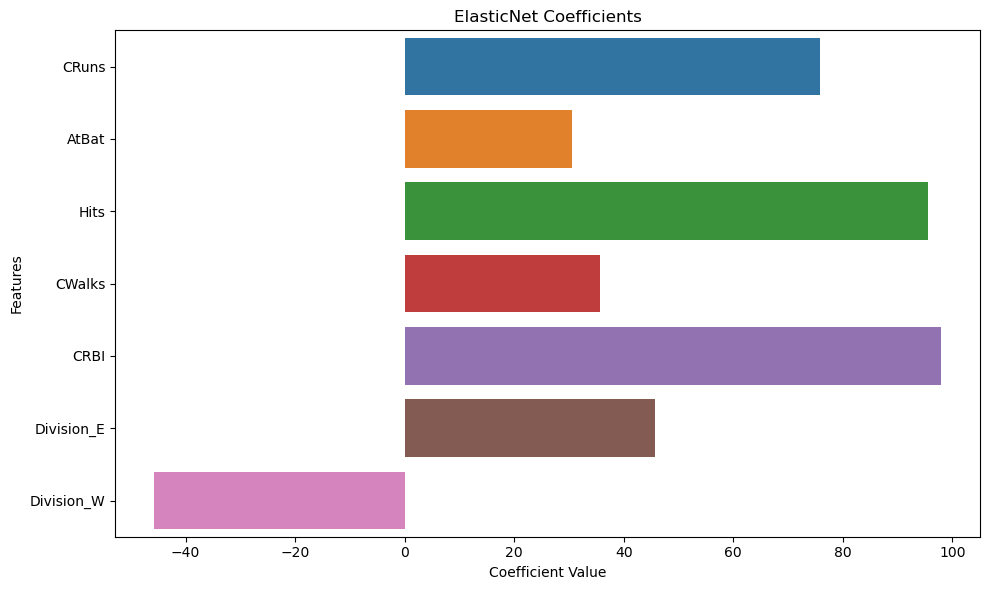

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=coefs, y=feature_names)
plt.title('ElasticNet Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.tight_layout()

plt.show()

This plot virtualized the impact of those selected predictor variables on predicted variable salary. CRBI has the greatest positive impact around 98 and the Division_W has the most negative impact of 45. The coefficient value explained how much each variable changes gonna effect the salary amout. 